#  importing libraries

In [1]:
import numpy  as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import seaborn as sns

In [2]:
data = pd.read_csv('adult_income_classification.csv')

#  EDA

In [3]:
data.head(2)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K


In [4]:
data[data.isin(['?'])].count()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [5]:
data.replace('?',np.nan,inplace=True)
data.head().T

,0,1,2,3,4
age,90,82,66,54,41
workclass,NaN,Private,NaN,Private,Private
fnlwgt,77053,132870,186061,140359,264663
education,HS-grad,HS-grad,Some-college,7th-8th,Some-college
education.num,9,9,10,4,10
marital.status,Widowed,Widowed,Widowed,Divorced,Separated
occupation,NaN,Exec-managerial,NaN,Machine-op-inspct,Prof-specialty
relationship,Not-in-family,Not-in-family,Unmarried,Unmarried,Own-child
race,White,White,Black,White,White
sex,Female,Female,Female,Female,Female


In [6]:
numerical_features = ['age','fnlwgt','capital.gain','capital.loss','hours.per.week']
categorical_features = ['workclass','marital.status','occupation','relationship','sex','native.country']
ordinal_features = ['education']
target_col = ['income']
drop_features = ['race','education.num']
education_order = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th',
    '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm',
    'Bachelors', 'Masters', 'Prof-school', 'Doctorate'
]

In [7]:
numerical_transformer = make_pipeline(MinMaxScaler())
categorical_transformer = make_pipeline(SimpleImputer(strategy='constant'),
                                        OneHotEncoder(handle_unknown='ignore',drop='if_binary',sparse=False))
ordinal_transformer = make_pipeline(OrdinalEncoder(categories=[education_order]))

<Axes: >

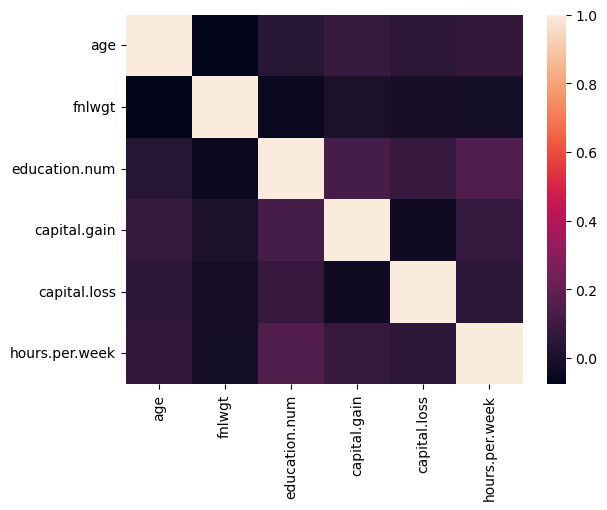

In [8]:
import warnings
warnings.filterwarnings('ignore')
sns.heatmap(data.corr())

# splitting data into train and test

In [9]:
x_train,x_test,y_train,y_test = train_test_split(data.drop(columns='income'),data['income'],test_size=0.2,random_state=123)

# here I converted target feature in binary because of XGBClassifier
y_train=y_train.replace({'<=50K':0,'>50K':1})
y_test=y_test.replace({'<=50K':0,'>50K':1})

In [10]:
preprocessor = make_column_transformer(
    (numerical_transformer,numerical_features),
    (categorical_transformer,categorical_features),
    (ordinal_transformer,ordinal_features),
    ('drop',drop_features),
    remainder ='passthrough'
)

In [11]:
# print(data['education'].value_counts().index,education_order)

# finding best Hyperparameter

In [12]:
pipe_df=make_pipeline(preprocessor,DecisionTreeClassifier(random_state=123,))

pipe_lgr = make_pipeline(preprocessor,LogisticRegression(random_state=123))

pipe_svc = make_pipeline(preprocessor,SVC(random_state=123))

# decisiontreeclassifier
param_df = {'decisiontreeclassifier__max_depth':[2,3,4,5,6,7,8,9,10,11,12,13]}
grid_df = GridSearchCV(pipe_df,param_grid=param_df,n_jobs=-1,return_train_score=True)
grid_df.fit(x_train,y_train)

# logisticregression
param_lgr = {'logisticregression__C':[0.0001,0.001,0.01,0.1,1,10,100,100],'logisticregression__max_iter':
             [10,100,200,500,600,800,1000]}
grid_lgr = GridSearchCV(pipe_lgr,param_grid=param_lgr,n_jobs=-1,return_train_score=True)
grid_lgr.fit(x_train,y_train)

# # svc
# param_svc = {'svc__C':[0.0001,0.001,0.01,0.1,1,10,100,100],"svc__gamma":[0.0001,0.001,0.01,0.1,1,10,100,100]}
# grid_svc = GridSearchCV(pipe_svc,param_grid=param_svc,n_jobs=-1,return_train_score=True)
# grid_svc.fit(x_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'capital.gain',
                                                                          'capital.loss',
                                                                          'hours.per.week']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHo...
                                                                                                                      'Assoc-acdm',
                                                                                                                      'Bachelors',
                                                                                                                      'Masters',
                                                                                                                      'Prof-school',
                                                                                                                      'Doctorate']]))]),
                                                                         ['education']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['race',
                                                                          'education.num'])])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=123))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 100],
                         'logisticregression__max_iter': [10, 100, 200, 500,
                                                          600, 800, 1000]},
             return_train_score=True)

In [13]:
pd.DataFrame(grid_df.cv_results_).sort_values('rank_test_score').T
grid_df.best_score_
best_param_df = grid_df.best_params_
best_param_df

{'decisiontreeclassifier__max_depth': 7}

In [14]:
best_param_df = grid_df.best_params_
best_param_lgr = grid_lgr.best_params_
# best_param_svc = grid_svc.best_params_

# Models

In [15]:
pipe_df=make_pipeline(preprocessor,DecisionTreeClassifier(random_state=123,
                                                          max_depth=best_param_df['decisiontreeclassifier__max_depth']))

pipe_lgr = make_pipeline(preprocessor,LogisticRegression(C=best_param_lgr['logisticregression__C'],
                                                         max_iter=best_param_lgr['logisticregression__max_iter']
                                                         ,random_state=123))

pipe_rf = make_pipeline(preprocessor,RandomForestClassifier(random_state=123,n_jobs=-1))

pipe_lgbm = make_pipeline(preprocessor,LGBMClassifier(random_state=123))

# pipe_svc = make_pipeline(preprocessor,SVC(C=best_param_svc['svc__C'],gamma=best_param_svc['svc__gamma'],random_state=123))

pipe_xgb = make_pipeline(preprocessor,XGBClassifier(random_state=123,eval_metric="logloss", verbosity=0))

models = [pipe_df,pipe_lgr,pipe_rf,pipe_lgbm,pipe_xgb,pipe_svc]



# creating result dataframe on model's name and its score 

In [16]:
m_name = ['pipe_df','pipe_lg','pipe_rf','pipe_lgbm','pipe_xgb','pip_svc']
score = []
for model in models:
    model.fit(x_train,y_train)
    score.append(model.score(x_test,y_test))

[LightGBM] [Info] Number of positive: 6238, number of negative: 19810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239481 -> initscore=-1.155527
[LightGBM] [Info] Start training from score -1.155527


In [19]:
result=dict(zip(m_name,np.round(score,3)))
result_mat=pd.DataFrame(data=result.values(),index=result.keys(),columns=['Test_score'])
result_mat

,Test_score
pipe_df,0.852
pipe_lg,0.853
pipe_rf,0.857
pipe_lgbm,0.875
pipe_xgb,0.873
pip_svc,0.828


In [20]:
result_mat.max()

Test_score    0.875
dtype: float64

In [26]:
print('best_model:',result_mat.iloc[np.argmax(result_mat)]) 

best_model: Test_score    0.875
Name: pipe_lgbm, dtype: float64


## lightgbm has the highest score of 87.5 percent